# Clockwork Axion Cosmology

In [165]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root
from skimage.measure import find_contours
import model
import plot_tools
import clock_work_axion
import reheating
import transport_equation
from common import constants, cosmology, util

In [247]:
clock_work_axion = importlib.reload(clock_work_axion)

## Baryon Asymmmetry Generation

In [2]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = clock_work_axion.calc_eps(mR)
f = 1e12
f_eff = clock_work_axion.calc_f_eff(f, eps)
M = m_phi / eps

In [3]:
m = model.AxionBaryogenesisModel(
    source_vector=transport_equation.source_vector_weak_sphaleron, 
    get_axion_source=clock_work_axion.get_axion_source_clockwork,
    axion_rhs=clock_work_axion.rhs_log_t,
    calc_axion_mass=clock_work_axion.calc_mass,
    axion_parameter=(eps, M),
    axion_initial=(clock_work_axion.theta_to_phi_over_f(1.0, eps), 0),
    Gamma_phi=Gamma_phi,
    H_inf=H_inf,
)

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:74: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/plot_tools.py:29: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / source_scale


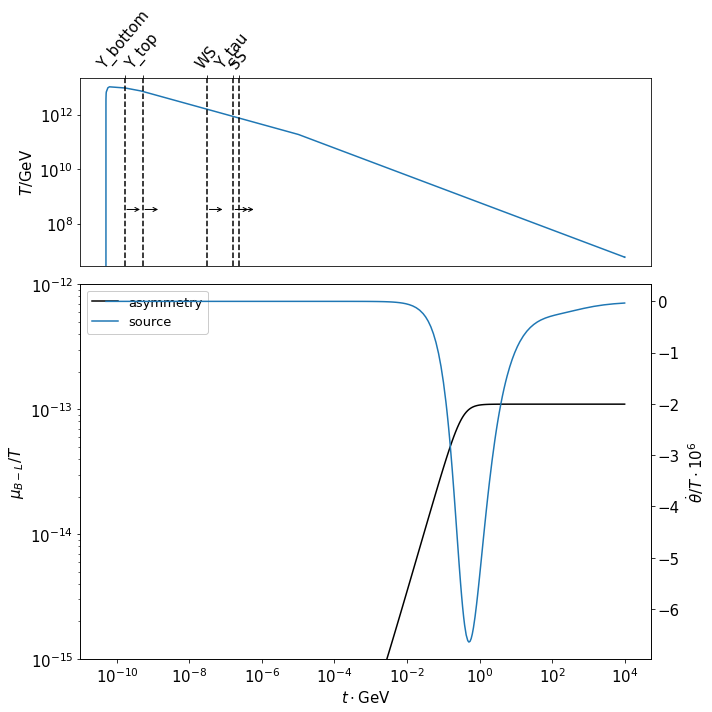

In [4]:
res = model.solve(m, collect=True, t_end=1e4)
plot_tools.plot(res, asymmetry_limits=(1e-15, 1e-12), source_scale=1e-9)

## Example Field Evolution

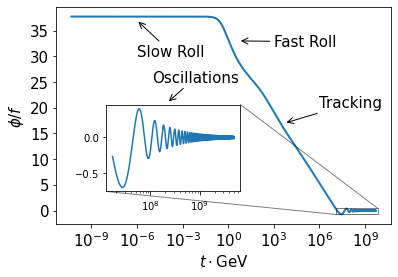

In [3]:
t0, initial = reheating.calc_initial_reheating(H_inf)
tf_2 = cosmology.switch_hubble_and_time_rad_dom(m_phi) * 1e3
T_fn, H_fn, _, final = reheating.solve_reheating_eq(t0, tf_2, initial, Gamma_phi)
sol = clock_work_axion.evolve(t0, tf_2, (clock_work_axion.theta_to_phi_over_f(1, eps), 0), (eps, M, H_fn))
plt.semilogx(sol.t, sol.y[0], lw=2)
plt.xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\phi / f$ ", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.annotate("Slow Roll", (1e-6, 37), (1e-6, 30), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Fast Roll", (5e0, 33), (1e3, 32), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Tracking", (0.5e4, 17), (1e6, 20), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Oscillations", (1e-4, 21), (1e-5, 25), arrowprops=dict(arrowstyle="->"), fontsize=15)
ax = plt.gca()
i = np.where(sol.y[0] < 0)[0][0]
inset_ax = ax.inset_axes([0.15, 0.15, 0.4, 0.4])
inset_ax.semilogx(sol.t[i:], sol.y[0, i:])
ax.indicate_inset_zoom(inset_ax, edgecolor="black");

## Deformed Potentials

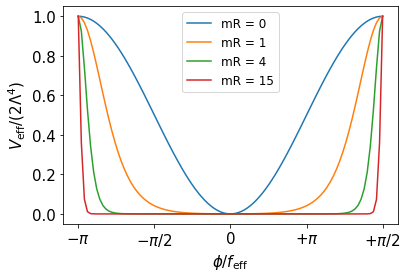

In [5]:
alpha_range = np.linspace(-np.pi, np.pi, 100)
for plot_mR in [0, 1, 4, 15]:
    eps = clock_work_axion.calc_eps(plot_mR)
    phi_over_f_range = clock_work_axion.calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = clock_work_axion.calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    plt.plot(alpha_range, y, label=f"mR = {plot_mR}")
plt.xlabel(r"$\phi / f_\mathrm{eff}$", fontsize=15)
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$", fontsize=15)
plt.legend(fontsize=12)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi$", r"$+\pi/2$"], fontsize=15)
plt.yticks(fontsize=15);

## Parameterspace of the Clockwork Model

In [193]:
N = 30
m_phi_range = np.geomspace(1e-6, 1e6, N) * 1e-9 # [GeV]
mR_range = np.linspace(0, 15, N)
sim_f_eff = f_eff = 1e13
H_inf = 1e8
Gamma_phi = H_inf

In [3]:
%time obs = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, relic_kwargs=dict(max_steps=100)) for m_phi in m_phi_range] for mR in mR_range])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:75: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:77: RuntimeWarning: overflow encountered in double_scalars
  return phi_dot_over_f * t, phi_dot_dot_over_f * t
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:55: RuntimeWarning: overflow encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
/home/jana/Documents/master-project/transport_eq_in_time/trans

Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than

In [3]:
filename = "clockwork.pkl"
# util.save_data(filename, obs)
obs, = util.load_data(filename)

In [126]:
def find_obs(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf):
    A = np.log10(obs[:, :, 0] / constants.eta_B_observed)
    sim_f = np.array([clock_work_axion.calc_f(sim_f_eff, clock_work_axion.calc_eps(mR)) for mR in mR_range])[:, None]
    actuall_f = np.array([clock_work_axion.calc_f(actuall_f_eff, clock_work_axion.calc_eps(mR)) for mR in mR_range])[:, None]
    B = np.log10(obs[:, :, 1] / sim_f**2 * actuall_f**2 / constants.Omega_DM_h_sq)
    return A, B

In [130]:
def plot_clockwork_parameter_space(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf, do_log=True):
    plt.figure(figsize=(8,4))
    num_lines = 10
    fts = 15
    inline_label_fs = 10
    
    A, B = find_obs(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf)
    
    ############################ baryon asymmetry #########################
    level = np.sort(np.concatenate([[0], np.linspace(np.nanmin(A), np.nanmax(A), num_lines)]))
    if do_log:
        C1 = plt.contour(m_phi_range * 1e9, mR_range, A, levels=level, cmap="viridis")
    else:
        C1 = plt.contour(np.log10(m_phi_range * 1e9), mR_range, A, levels=level, cmap="viridis")

    cbar1 = plt.colorbar(pad=0.08)
    cbar1.set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$", fontsize=fts)
    C1.collections[np.where(C1.levels == 0)[0][0]].set_color("red")
    C1.collections[np.where(C1.levels == 0)[0][0]].set_linewidths(3)
    #plt.gca().clabel(C1, inline=mφ [eV]True, fontsize=inline_label_fs)

    ################################ relic density #############################
    if do_log:
        level = np.sort(np.concatenate([[0], np.linspace(np.nanmin(B), np.nanmax(B), num_lines)]))
    else:
        level = np.unique(np.concatenate([[0], np.arange(np.ceil(np.nanmin(B)), np.floor(np.nanmax(B)), 1)]))
    
    if do_log:
        C2 = plt.contour(m_phi_range * 1e9, mR_range, B, levels=level, cmap="plasma", linestyles="--")
    else:
        C2 = plt.contour(np.log10(m_phi_range * 1e9), mR_range, B, levels=level, cmap="plasma", linestyles="--")
        
    cbar2 = plt.colorbar()
    cbar2.set_label(r"$\log_{10} ( \Omega_a / \Omega_a^{\mathrm{obs}})$", fontsize=fts)
    C2.collections[np.where(C2.levels == 0)[0][0]].set_linewidths(3)
    C2.collections[np.where(C2.levels == 0)[0][0]].set_color("red")
    #plt.gca().clabel(C2, inline=True, fontsize=inline_label_fs)

    # constrains 
    if do_log:
        # interference with inflation
        plt.fill_between(m_phi_range * 1e9, [clock_work_axion.get_max_mR(m_phi, H_inf, 1.0) for m_phi in m_phi_range], [mR_range[-1]]*len(m_phi_range), 
                         color="blue", alpha=0.5)
        # decay
        plt.fill_between(m_phi_range * 1e9, [clock_work_axion.get_min_mR(m_phi, actuall_f_eff) for m_phi in m_phi_range], [mR_range[0]]*len(m_phi_range), 
                         color="green", alpha=0.5)
    else:
        plt.fill_between(np.log10(m_phi_range * 1e9), [clock_work_axion.get_max_mR(m_phi, H_inf, 1.0) for m_phi in m_phi_range], 
                         [mR_range[-1]]*len(m_phi_range), color="blue", alpha=0.5)
        # decay
        plt.fill_between(np.log10(m_phi_range * 1e9), [clock_work_axion.get_min_mR(m_phi, actuall_f_eff) for m_phi in m_phi_range], 
                         [mR_range[0]]*len(m_phi_range), color="green", alpha=0.5)
        
    if do_log:
        plt.xlim(m_phi_range[0] * 1e9, m_phi_range[-1] * 1e9)
    else:
        plt.xlim(np.log10(m_phi_range[0] * 1e9), np.log10(m_phi_range[-1] * 1e9))
        
    plt.ylim(mR_range[0], mR_range[-1])
    if do_log:
        plt.xlabel("$m_\phi$ / eV", fontsize=fts)
    else:
        plt.xlabel("$\log_{10}(m_\phi$ / eV)", fontsize=fts)

    plt.ylabel("mR", fontsize=fts)
    plt.xticks(fontsize=fts)
    plt.yticks(fontsize=fts)
    if do_log:
        plt.xscale("log")
    plt.title(f"$f_\\mathrm{{eff}} = {util.latex_exponential_notation(actuall_f_eff, 2)}$ GeV", fontsize=fts)
    plt.tight_layout()

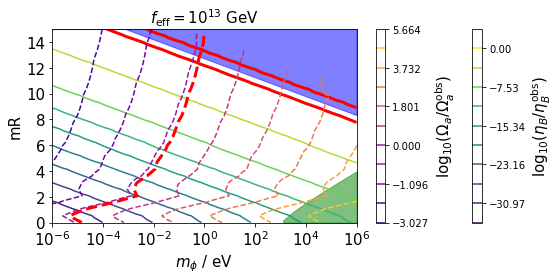

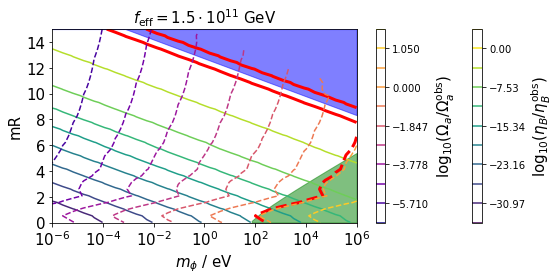

In [132]:
plot_clockwork_parameter_space(m_phi_range, mR_range, obs, f_eff, 1e13, H_inf)
plt.show()
plot_clockwork_parameter_space(m_phi_range, mR_range, obs, f_eff, 1.5e11, H_inf)
plt.show()

## Comparison with the plot in the paper

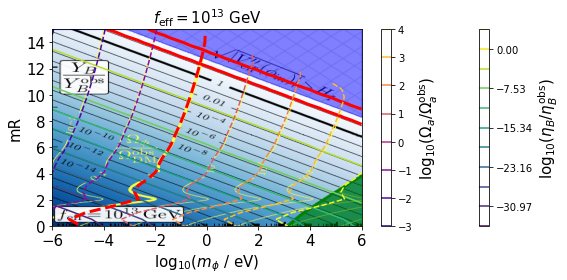

In [131]:
im = plt.imread("../1811.10655/paper_result.png-1.png")
plot_clockwork_parameter_space(m_phi_range, mR_range, obs, f_eff, 1e13, H_inf, do_log=False)
plt.imshow(im, aspect="auto", extent=[np.log10(m_phi_range[0] * 1e9), np.log10(m_phi_range[-1] * 1e9), mR_range[0], mR_range[-1]])
plt.tight_layout()
plt.savefig(util.make_plot_path("clockwork_comparision_to_paper.pdf"))

## Plot of $\sqrt{V''_\mathrm{eff}} / H_\mathrm{inf}$ and the correct $\eta_B$ contours 

In [146]:
def find_correct_contours(m_phi_range, mR_range, observable, print_f=False):
    m_phi_interp = interp1d(np.arange(len(m_phi_range)), np.log10(m_phi_range))
    mR_interp = interp1d(np.arange(len(mR_range)), mR_range)
    for c in find_contours(observable, 0.0):
        rows, cols = c.T
        m_phi = 10**m_phi_interp(cols) * 1e9
        mR = mR_interp(rows)
        if print_f:
            print(np.mean(f(mR_interp(rows), 10**m_phi_interp(cols))))
        yield mR, m_phi

-0.756103500664382
0.7950047477330617


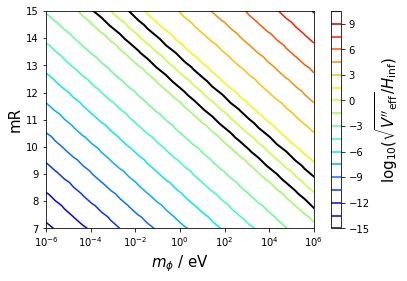

In [149]:
m_phi_range_local = m_phi_range
mR_range_local = np.linspace(7, 15, 20)

def f(mR, m_phi):
    eps = clock_work_axion.calc_eps(mR)
    M = clock_work_axion.calc_mass_scale(m_phi, eps)
    return np.log10(np.sqrt(clock_work_axion.calc_d2V_eff_dphi2(clock_work_axion.theta_to_phi_over_f(1.0, eps), eps, M)) / H_inf)
inflation_constraint = [[f(mR, m_phi) for m_phi in m_phi_range_local] for mR in mR_range_local]

plt.contour(m_phi_range_local * 1e9, mR_range_local, inflation_constraint, levels=20, cmap="jet")
plt.xscale("log")
plt.colorbar().set_label("$\log_{10}(\sqrt{V''_\mathrm{eff}} / H_\mathrm{inf})$", fontsize=fts)

A, B = find_obs(m_phi_range, mR_range, obs, f_eff, f_eff, H_inf)
for mR, m_phi in find_correct_contours(m_phi_range, mR_range, A, print_f=True):
    plt.plot(m_phi, mR, lw=2, color="k")

plt.ylim(mR_range_local[0],  mR_range_local[-1])
plt.xscale("log")
fts = 15
plt.xlabel("$m_\phi$ / eV", fontsize=fts)
plt.ylabel("mR", fontsize=fts)
plt.show()

## Find the points where $\eta_B = \eta_B^\mathrm{obs}$ and $\Omega_\phi = \Omega_\mathrm{DM}$

In [236]:
def find_intersection(m_phi_eta, mR_eta, m_phi_Omega, mR_Omega):
    assert len(mR_eta) == len(m_phi_eta) 
    assert len(mR_Omega) == len(m_phi_Omega)
    mR_eta_interp      = interp1d(np.arange(len(mR_eta)), mR_eta) 
    m_phi_eta_interp   = interp1d(np.arange(len(m_phi_eta)), np.log10(m_phi_eta))
    mR_Omega_interp    = interp1d(np.arange(len(mR_Omega)), mR_Omega) 
    m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
    def goal(I):
        i_eta, i_Omega = I # index into curve one (eta) and index into curve two (Omega)
        # the two curves should intersection i.e. both variables from each curve are equal
        try:
            return (
                mR_eta_interp(i_eta) / mR_Omega_interp(i_Omega) - 1,
                m_phi_eta_interp(i_eta) / m_phi_Omega_interp(i_Omega) - 1, 
            )
        except ValueError:
            return np.nan, np.nan # evaluation outside of the curves is undefined
    initial_guess = len(mR_eta) / 2, len(mR_Omega) / 2
    sol = root(goal, initial_guess, method="lm")
    if sol.success:
        i_eta_sol, i_Omega_sol = sol.x
        return 10**m_phi_eta_interp(i_eta_sol), mR_eta_interp(i_eta_sol)
    else:
        print(sol)
        raise ValueError

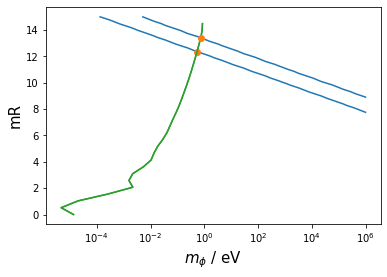

In [237]:
actuall_f_eff = 1e13
A, B = find_obs(m_phi_range, mR_range, obs, f_eff, f_eff, H_inf)
for mR_eta, m_phi_eta in find_correct_contours(m_phi_range, mR_range, A):
    plt.plot(m_phi_eta, mR_eta, color="tab:blue")
    for mR_Omega, m_phi_Omega in find_correct_contours(m_phi_range, mR_range, B):
        plt.plot(m_phi_Omega, mR_Omega, color="tab:green")
        try:
            m_phi, mR = find_intersection(m_phi_eta, mR_eta, m_phi_Omega, mR_Omega)
            plt.plot([m_phi], [mR], "o", color="tab:orange")
        except ValueError:
            pass
plt.xlabel("$m_\phi$ / eV", fontsize=fts)
plt.ylabel("mR", fontsize=fts)
plt.xscale("log")

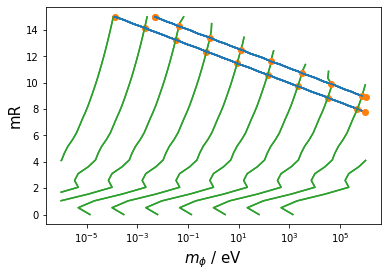

In [238]:
for actuall_f_eff in np.geomspace(1e14, 1e11, 10):
    A, B = find_obs(m_phi_range, mR_range, obs, f_eff, actuall_f_eff, H_inf)
    for mR_eta, m_phi_eta in find_correct_contours(m_phi_range, mR_range, A):
        plt.plot(m_phi_eta, mR_eta, color="tab:blue")
        for mR_Omega, m_phi_Omega in find_correct_contours(m_phi_range, mR_range, B):
            plt.plot(m_phi_Omega, mR_Omega, color="tab:green")
            try:
                m_phi, mR = find_intersection(m_phi_eta, mR_eta, m_phi_Omega, mR_Omega)
                plt.plot([m_phi], [mR], "o", color="tab:orange")
            except ValueError:
                pass
plt.xlabel("$m_\phi$ / eV", fontsize=fts)
plt.ylabel("mR", fontsize=fts)
plt.xscale("log")

In [239]:
def find_intersections(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf):
    A, B = find_obs(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf)
    for mR_eta, m_phi_eta in find_correct_contours(m_phi_range, mR_range, A):
        for mR_Omega, m_phi_Omega in find_correct_contours(m_phi_range, mR_range, B):
            try:
                m_phi, mR = find_intersection(mR_eta, m_phi_eta, mR_Omega, m_phi_Omega)
                if np.isfinite(m_phi) and np.isfinite(mR):
                    yield mR, m_phi, actuall_f_eff
            except ValueError:
                pass

<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))
<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_

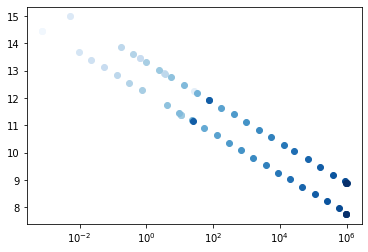

In [240]:
f_eff_range = np.geomspace(1e14, 1e11, 30)

cmap = plt.get_cmap("Blues")
for actuall_f_eff in f_eff_range:
    m_phis, mRs, actuall_f_effs = np.array(list(find_intersections(m_phi_range, mR_range, obs, f_eff, actuall_f_eff, H_inf))).T
    x = (np.log10(actuall_f_eff) - np.log10(f_eff_range[0])) / (np.log10(f_eff_range[-1]) - np.log10(f_eff_range[0]))
    c = cmap(x)
    plt.plot(m_phis, mRs, "o", color=c)
plt.xscale("log")

In [250]:
def find_correct_points():
    for actuall_f_eff in f_eff_range:
        yield from find_intersections(m_phi_range, mR_range, obs, f_eff, actuall_f_eff, H_inf)
points = list(find_correct_points())

<ipython-input-236-c76c9619a285>:7: RuntimeWarning: divide by zero encountered in log10
  m_phi_Omega_interp = interp1d(np.arange(len(m_phi_Omega)), np.log10(m_phi_Omega))


In [253]:
points_ = [(m_phi, clock_work_axion.calc_axion_photon_coupling(mR, f_eff)) for m_phi, mR, f_eff in points]

Text(0.5, 0, 'm_phi / eV')

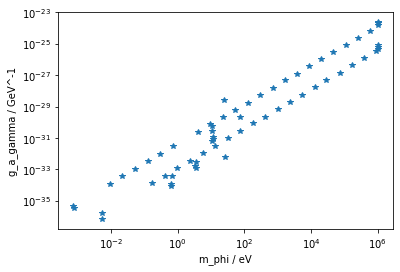

In [262]:
plt.loglog([m_phi for m_phi, mR, f_eff in points], [clock_work_axion.calc_axion_photon_coupling(mR, f_eff) for m_phi, mR, f_eff in points], "*")
plt.ylabel("g_a_gamma / GeV^-1")
plt.xlabel("m_phi / eV")

In [254]:
util.save_data("correct_clockwork_points.pkl", np.array(points_).T)

In [255]:
np.array(points).T[1]

array([14.44415879, 14.98967476, 14.44951965, 13.46685477, 11.39757392,
       13.47015934, 11.38605731, 12.24964642, 11.38612823, 14.98949524,
       13.69488006, 12.91818965, 13.39432358, 12.9238365 , 13.13312642,
       13.45404243, 11.39456775, 12.84809413, 12.89812431, 13.87617303,
       12.57130199, 13.61812079, 12.28892467, 13.34102697, 11.39755309,
       13.04036371, 11.73344429, 12.77381827, 11.45997599, 12.48606834,
       11.20281888, 12.1932819 , 10.90749546, 11.93842287, 10.6647718 ,
       11.64695569, 10.35684874, 11.40434682, 10.118631  , 11.12896694,
        9.81634814, 10.84028617,  9.5693897 , 10.59379059,  9.27381894,
       10.30045958,  9.03462971, 10.05680956,  8.74647479,  9.78042918,
        8.51006734, 11.1762587 ,  9.47863174, 11.94979723,  8.22320227,
        9.19486352,  7.97762894,  8.96051971,  7.75739714,  8.90986451,
        7.75860432,  8.90711341,  7.75858931,  8.91028791])

## Dependence on Inflation Parameters $H_\mathrm{inf}$ and $\Gamma_\mathrm{inf}$ 

In [26]:
mR = 13
m_phi = 1e-1 * 1e-9
f_eff = 1e13
H_inf_range = [1e8, 1e10, 1e12]
Gamma_phi_over_H_inf_range = np.geomspace(1e-6, 1, 20)
obs_inf = [[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) 
          for Gamma_phi in H_inf * Gamma_phi_over_H_inf_range] 
          for H_inf in H_inf_range]

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:8: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:39: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: invalid value encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:105: RuntimeWarning: invalid value encountered in true_divide
  gamma = Gamma / (T**3 / 6) # rate per unit time
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: overflow encountered in double_scalars
  (Gamma_phi * rho_phi

Text(0.5, 1.0, '$mR = 13, m_\\phi = 10^{-1} $ eV')

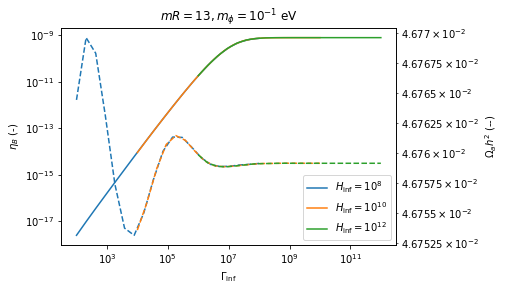

In [45]:
eta_label = r"$\eta_B$"
Omega_label = r"$\Omega_a h^2$"
plt.xlabel(r"$\Gamma_\mathrm{inf}$")
ax = plt.gca()
ax_twin = ax.twinx()
ax_twin.set_yscale("log")

for color, H_inf, O in zip(["tab:blue", "tab:orange", "tab:green"], H_inf_range, obs_inf):
    eta_inf, Omega_inf = np.array(O).T
    ax.loglog(H_inf * Gamma_phi_over_H_inf_range, eta_inf, label=f"$H_\\mathrm{{inf}} = {util.latex_exponential_notation(H_inf)}$", ls="-", color=color)
    ax_twin.plot(H_inf * Gamma_phi_over_H_inf_range, Omega_inf, ls="--", color=color)
    
ax_twin.set_ylabel(Omega_label)
ax.legend(loc=4)
ax.set_ylabel(eta_label + " (-)")
ax_twin.set_ylabel(Omega_label + " (--)")

plt.title(f"$mR = {mR}, m_\\phi = {util.latex_exponential_notation(m_phi * 1e9, 2)} $ eV")

## Parameterspace like in the default model

In [47]:
mR = 13
f_eff = 1e13
H_inf = 1e10
obs_std_param_space = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) 
                        for m_phi in m_phi_range] for Gamma_phi in H_inf * Gamma_phi_over_H_inf_range])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: overflow encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:8: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:39: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: invalid value encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:105: RuntimeWarning: invalid value encountered in true_divide
  gamma = Gamma / (T**3 / 6) # rate per unit time


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:182: RuntimeWarning: invalid value encountered in multiply
  - (rate(T) * (charge_vector @ red_chem_pots - n_S * theta_dot / T / unit)) @ charge_vector / dofs
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:182: RuntimeWarning: invalid value encountered in matmul
  - (rate(T) * (charge_vector @ red_chem_pots - n_S * theta_dot / T / unit)) @ charge_vector / dofs
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: overflow encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:68: RuntimeWarning: invalid value encountered in double_scalars
  1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than

<ipython-input-49-00a4c33e2209>:1: RuntimeWarning: invalid value encountered in log10
  plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 0] / constants.eta_B_observed))


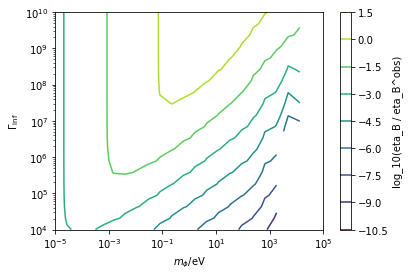

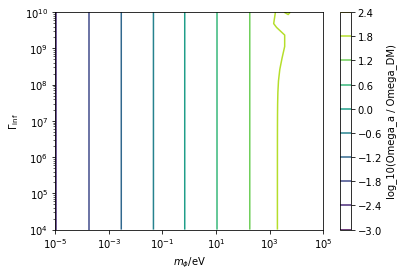

In [49]:
plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 0] / constants.eta_B_observed))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\phi / \mathrm{eV}$")
plt.ylabel(r"$\Gamma_\mathrm{inf}$")
plt.colorbar().set_label("log_10(eta_B / eta_B^obs)")
plt.show()
plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 1] / constants.Omega_DM_h_sq))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\phi / \mathrm{eV}$")
plt.ylabel(r"$\Gamma_\mathrm{inf}$")
plt.colorbar().set_label("log_10(Omega_a / Omega_DM)")

## Dependence on $\theta_i$

In [2]:
theta_range = np.linspace(0, np.pi - 1e-3, 20)
mR = 13
m_phi = 1e-1 * 1e-9
f_eff = 1e13
Gamma_phi = H_inf = 1e8
obs_theta = np.array([clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, theta_i=theta_i) for theta_i in theta_range])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: invalid value encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)


Required step size is less than spacing between numbers.


Text(0.5, 1.0, '$mR = 13, m_\\phi = 10^{-1} $ eV')

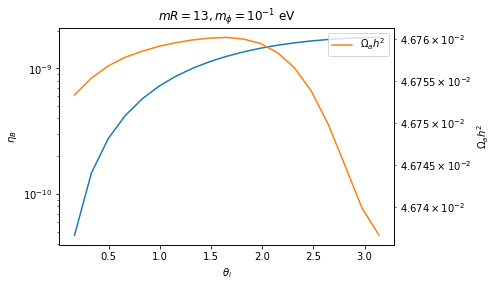

In [25]:
eta_B_theta, Omega_a_h_sq_theta = obs_theta.T
plt.semilogy(theta_range, eta_B_theta, label=eta_label, color="tab:blue")
plt.xlabel("$\\theta_i$")
plt.ylabel(eta_label)
ax_twin = plt.gca().twinx()
ax_twin.set_yscale("log")
ax_twin.plot(theta_range, Omega_a_h_sq_theta, label=Omega_label, color="tab:orange")
ax_twin.set_ylabel(Omega_label)
plt.legend()
plt.title(f"$mR = {mR}, m_\\phi = {util.latex_exponential_notation(m_phi * 1e9, 2)} $ eV")

## Experimental Detection

Text(0, 0.5, 'g_phi,gamma [1/GeV]')

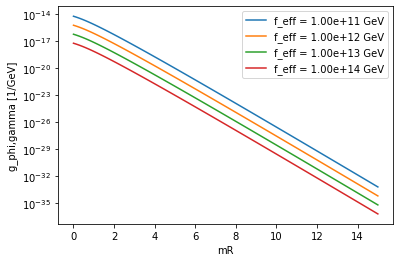

In [4]:
mR_range = np.linspace(0, 15, 100)
for f_eff in [1e11, 1e12, 1e13, 1e14]:
    plt.semilogy(mR_range, calc_axion_photon_coupling(mR_range, f_eff), label=f"f_eff = {f_eff:.2e} GeV")
plt.xlabel("mR")
plt.legend()
plt.ylabel("g_phi,gamma [1/GeV]")

In [6]:
sin_sq_theta_w = 0.22290
theta_w = np.arcsin(np.sqrt(sin_sq_theta_w))

In [7]:
np.sin(theta_w) * constants.g_2 

0.3078241082176638

In [8]:
np.cos(theta_w) * constants.g_1

0.3147071939120553

## Optimize the Relic density solver

In [3]:
clock_work_axion = importlib.reload(clock_work_axion)

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the s

change: 1.0084716440742425 Y: 118.04084204156425 convergence_eps: 0.01
change: 0.0006709602598908503 Y: 118.120095931829 convergence_eps: 0.01


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:123: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the s

change: 1.0049358491214315 Y: 202.5993857182545 convergence_eps: 0.01
change: 0.0021034498493515703 Y: 202.17412259054862 convergence_eps: 0.01


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:123: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the s

change: 1.0096131380123514 Y: 104.02430493717647 convergence_eps: 0.01
change: 0.0007080985914230948 Y: 103.95069759463226 convergence_eps: 0.01


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:123: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the s

change: 1.0317208882572837 Y: 31.52496840218139 convergence_eps: 0.01
change: 0.0012160681714877921 Y: 31.486678454686775 convergence_eps: 0.01


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:123: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:134: MatplotlibDeprecationWarning: Adding an axes using the s

change: 1.102473571588026 Y: 9.75861370403186 convergence_eps: 0.01
change: 0.002490113179869902 Y: 9.734374011009264 convergence_eps: 0.01


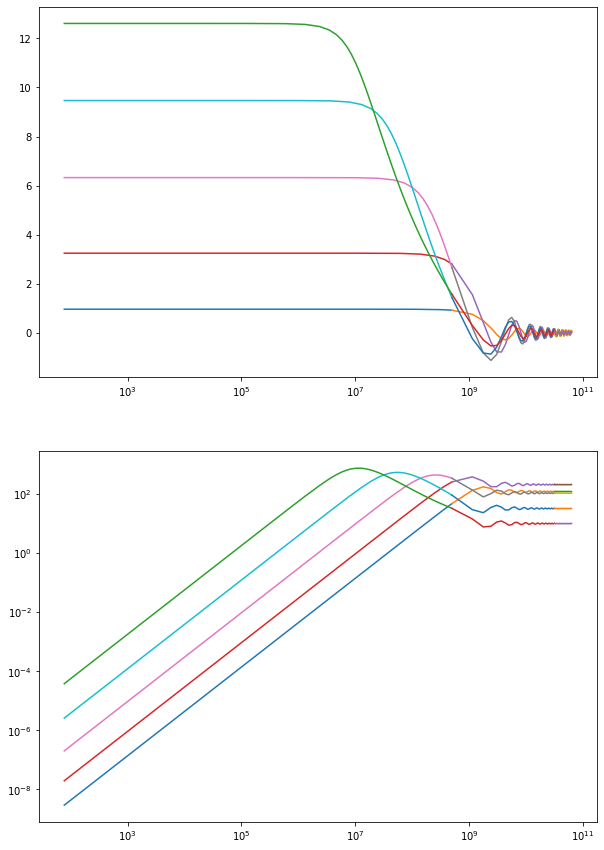

In [16]:
plt.figure(figsize=(10,15))
mR = 0
f_eff = 1e13
m_phi = 1 / 1e9 # [GeV]
Gamma_phi = H_inf = 1e8

for mR in np.linspace(0, 2, 5):
    clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, relic_kwargs=dict(debug=True))
#plt.xscale("linear")
#plt.subplot(2,1,1)
#plt.xscale("linear")